<a href="https://colab.research.google.com/github/quickgrid/AI-Resources/blob/master/paper-implementations/pytorch/neural-style-transfer/Pytorch_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### References
- Neural style transfer video, https://www.youtube.com/watch?v=imX4kSKDY7s.
- Neural style transfer code, https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/more_advanced/neuralstyle.
- Neural style Gatys 2016, https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf
- Neural style Gatys 2015, https://arxiv.org/abs/1508.06576

In [1]:
!mkdir "data"

In [2]:
!!wget "https://www.motormemos.com/wp-content/uploads/2019/10/2019-BMW-X5-xDrive50i-front-three-quarter-in-motion-4.jpg" -O "data/content_image.png"

['--2021-10-28 13:09:27--  https://www.motormemos.com/wp-content/uploads/2019/10/2019-BMW-X5-xDrive50i-front-three-quarter-in-motion-4.jpg',
 'Resolving www.motormemos.com (www.motormemos.com)... 69.163.232.164',
 'Connecting to www.motormemos.com (www.motormemos.com)|69.163.232.164|:443... connected.',
 'HTTP request sent, awaiting response... 200 OK',
 'Length: 244412 (239K) [image/jpeg]',
 'Saving to: ‘data/content_img.png’',
 '',
 '',
 'data/content_img.pn   0%[                    ]       0  --.-KB/s               ',
 'data/content_img.pn 100%[===================>] 238.68K  --.-KB/s    in 0.1s    ',
 '',
 '2021-10-28 13:09:27 (1.63 MB/s) - ‘data/content_img.png’ saved [244412/244412]',
 '']

In [3]:
!wget "https://wallpaperset.com/w/full/2/2/9/207342.jpg" -O "data/style_image.png"

--2021-10-28 13:09:28--  https://wallpaperset.com/w/full/2/2/9/207342.jpg
Resolving wallpaperset.com (wallpaperset.com)... 46.101.180.115
Connecting to wallpaperset.com (wallpaperset.com)|46.101.180.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1928471 (1.8M) [image/jpeg]
Saving to: ‘data/style_image.png’

data/style_image.pn 100%[===================>]   1.84M  2.85MB/s    in 0.6s    

2021-10-28 13:09:29 (2.85 MB/s) - ‘data/style_image.png’ saved [1928471/1928471]



In [7]:
!nvidia-smi

Thu Oct 28 13:10:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    75W / 149W |    554MiB / 11441MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [64]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image


# model = models.vgg19(pretrained=True).features
# print(model)

In [65]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()

        self.chosen_features = ["0", "5", "10", "19", "28"]
        self.model = models.vgg19(pretrained=True).features[:29]

    def forward(self, X):
        features = []

        for layer_num, layer in enumerate(self.model):
            X = layer(X)

            if str(layer_num) in self.chosen_features:
                features.append(X)

        return features

In [66]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGG().to(device=device).eval()
image_size = 512

image_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[], std=[])                                       
])

In [67]:
def load_image(image_path):
    image = Image.open(image_path)
    image = image_transforms(image).unsqueeze(0)
    return image.to(device=device)

In [68]:
content_image = load_image('data/content_image.png')
style_image = load_image('data/style_image.png')

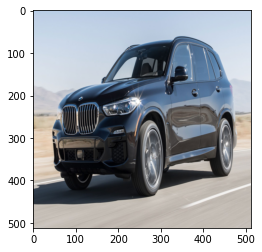

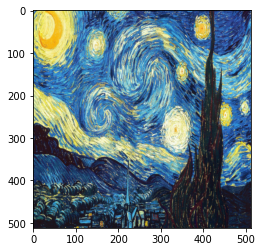

In [69]:
import matplotlib.pyplot as plt

content_image_copy = content_image.clone().to('cpu')
style_image_copy = style_image.clone().to('cpu')

plt.imshow(content_image_copy.squeeze().permute(1, 2, 0))
plt.show()
plt.imshow(style_image_copy.squeeze().permute(1, 2, 0))
plt.show()

In [94]:
# Using clone of input gives result much faster than using random gaussian noise.
# generated_image = torch.randn(content_image.shape, device=device, requires_grad=True)
generated_image = content_image.clone().requires_grad_(True)

In [95]:
total_steps = 6000
learning_rate = 0.001
alpha = 1 
# beta = 0.1
beta = 0.1
optimizer = optim.Adam([generated_image], lr=learning_rate)

for step in range(total_steps):
    generated_image_features = model(generated_image)
    content_image_features = model(content_image)
    style_image_features = model(style_image)

    content_loss = 0
    style_loss = 0

    # Get selected convolutional layer feature maps from each of content, style and generated image from model.
    for generated_image_feature, content_image_feature, style_image_feature in zip(
        generated_image_features,
        content_image_features,
        style_image_features,
    ):
        batch_size, channel, height, width = generated_image_feature.shape

        content_loss += torch.mean((generated_image_feature - content_image_feature) ** 2)  
        # content_loss += 0.5 * torch.sum((generated_image_feature - content_image_feature) ** 2)  

        # # Gram Matrix
        # G = generated_image_feature.view(channel, height * width).mm(
        #     generated_image_feature.view(channel, height * width).t()
        # )
        # # Compute Gram Matrix of Style
        # A = style_image_feature.view(channel, height * width).mm(
        #     style_image_feature.view(channel, height * width).t()
        # )

        G = torch.matmul(generated_image_feature.view(channel, height * width), generated_image_feature.view(channel, height * width).t())
        A = torch.matmul(style_image_feature.view(channel, height * width), style_image_feature.view(channel, height * width).t())
        # A = torch.matmul(content_image_feature.view(channel, height * width), content_image_feature.view(channel, height * width).t())
        
        # G = (generated_image_feature.view(channel, height * width)) @ (generated_image_feature.view(channel, height * width).T)
        # A = (style_image_feature.view(channel, height * width)) @ (style_image_feature.view(channel, height * width).T)
        # A = (content_image_feature.view(channel, height * width).T) @ (content_image_feature.view(channel, height * width))

        style_loss += torch.mean((G - A) ** 2)

    total_loss = alpha * content_loss + beta * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 20 == 0:
        print(f'Step: {step} \t TOTAL LOSS: {total_loss}')
        save_image(generated_image, 'generated.png')

Step: 0 	 TOTAL LOSS: 70524416.0
Step: 20 	 TOTAL LOSS: 44947808.0
Step: 40 	 TOTAL LOSS: 24072454.0
Step: 60 	 TOTAL LOSS: 13376663.0
Step: 80 	 TOTAL LOSS: 7887725.0
Step: 100 	 TOTAL LOSS: 5340051.5
Step: 120 	 TOTAL LOSS: 4046600.0
Step: 140 	 TOTAL LOSS: 3267290.25
Step: 160 	 TOTAL LOSS: 2735150.25
Step: 180 	 TOTAL LOSS: 2343941.25
Step: 200 	 TOTAL LOSS: 2043238.75
Step: 220 	 TOTAL LOSS: 1806138.0
Step: 240 	 TOTAL LOSS: 1615082.0
Step: 260 	 TOTAL LOSS: 1458169.75
Step: 280 	 TOTAL LOSS: 1327177.375
Step: 300 	 TOTAL LOSS: 1216293.625
Step: 320 	 TOTAL LOSS: 1121311.75
Step: 340 	 TOTAL LOSS: 1038998.3125
Step: 360 	 TOTAL LOSS: 966861.625
Step: 380 	 TOTAL LOSS: 903079.5625


KeyboardInterrupt: ignored

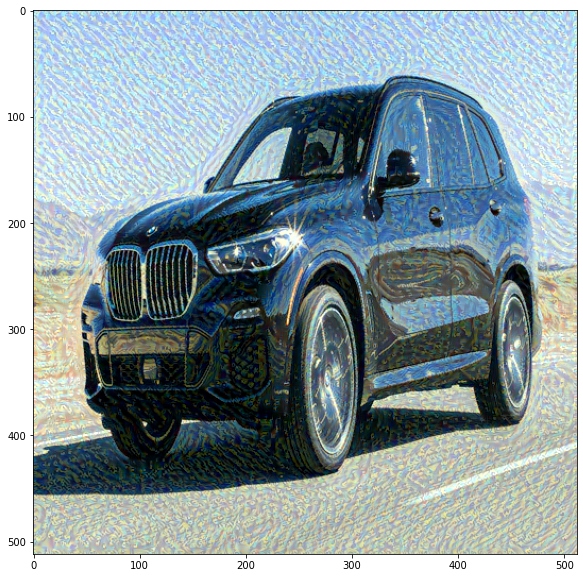

In [103]:
import matplotlib.pyplot as plt

gen_img = Image.open('generated.png')
plt.figure(figsize=(10,10))
plt.imshow(gen_img)
plt.show()